# 07. 生成モデル 解説

本章では生成モデルの代表例であるオートエンコーダーを実装しました。

datasetはMNISTで、0～9の手書き数字の画像がラベルと一緒に格納されています。これを学習用と検証用に分けて利用します。


## ライブラリのインポート

In [ ]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

## データセットの用意

データセットはpytorchに含まれているため、簡単に呼び出してローカルに保存できます。

さらに前処理はComposeでひとまとめにします。「ToTensor」はデータセットをテンソル化する関数、「Lambda」は「view(-1)」を表す自作関数で、データセットを一次元配列化する役割を担っています。

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))])

batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 15

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



データを確認して順番に5つ表示してみましょう。

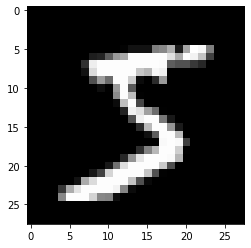

label:  tensor(5)


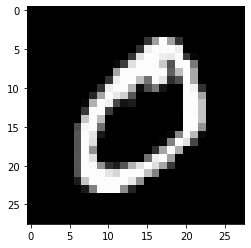

label:  tensor(0)


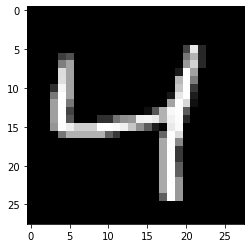

label:  tensor(4)


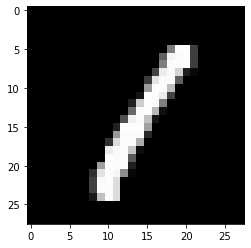

label:  tensor(1)


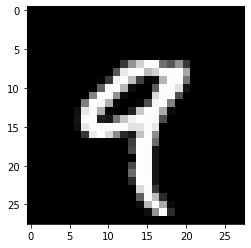

label:  tensor(9)


In [ ]:
# データの確認
batch_train = next(iter(dataloader_train))

# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(batch_train[0][i].reshape((28,28)))
    plt.show()
    print("label: ", batch_train[1][i])

## AEによるMNISTの画像生成（PyTorch）

オートエンコーダーは、エンコーダーで元の画像を低次元の特徴量に圧縮して、デコーダーで低次元の特徴量から元の画像を復元させるようなネットワークです。



# AE(Auto Encoder)

AEとはエンコーダーとデコーダーの2つのニューラルネットワークを結合したモデルで、データの圧縮や異常検知に使われます。

Encoder-Decoderモデルでは、<font color="Green">Encoder</font>により潜在変数に落とし込み（情報を圧縮し）、<font color="Blue">Decoder</font>により潜在変数からデータ生成を行います。

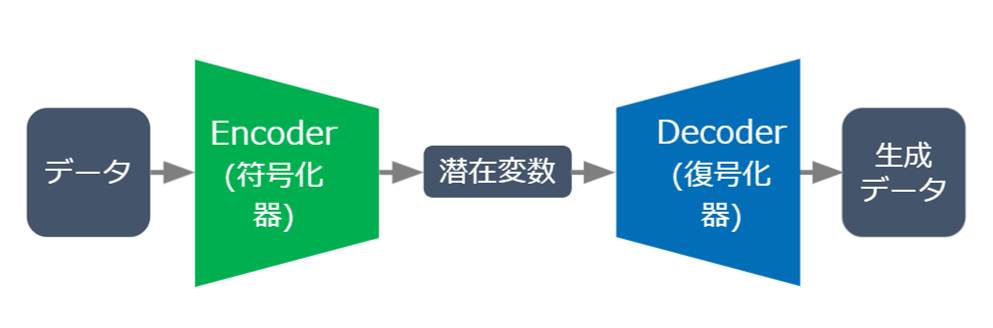

今回実装するモデルの構造は
```
Encoder: 512次元→64次元→32次元→10次元
Decoder: 10次元→32次元→64次元→512次元
```
とします。



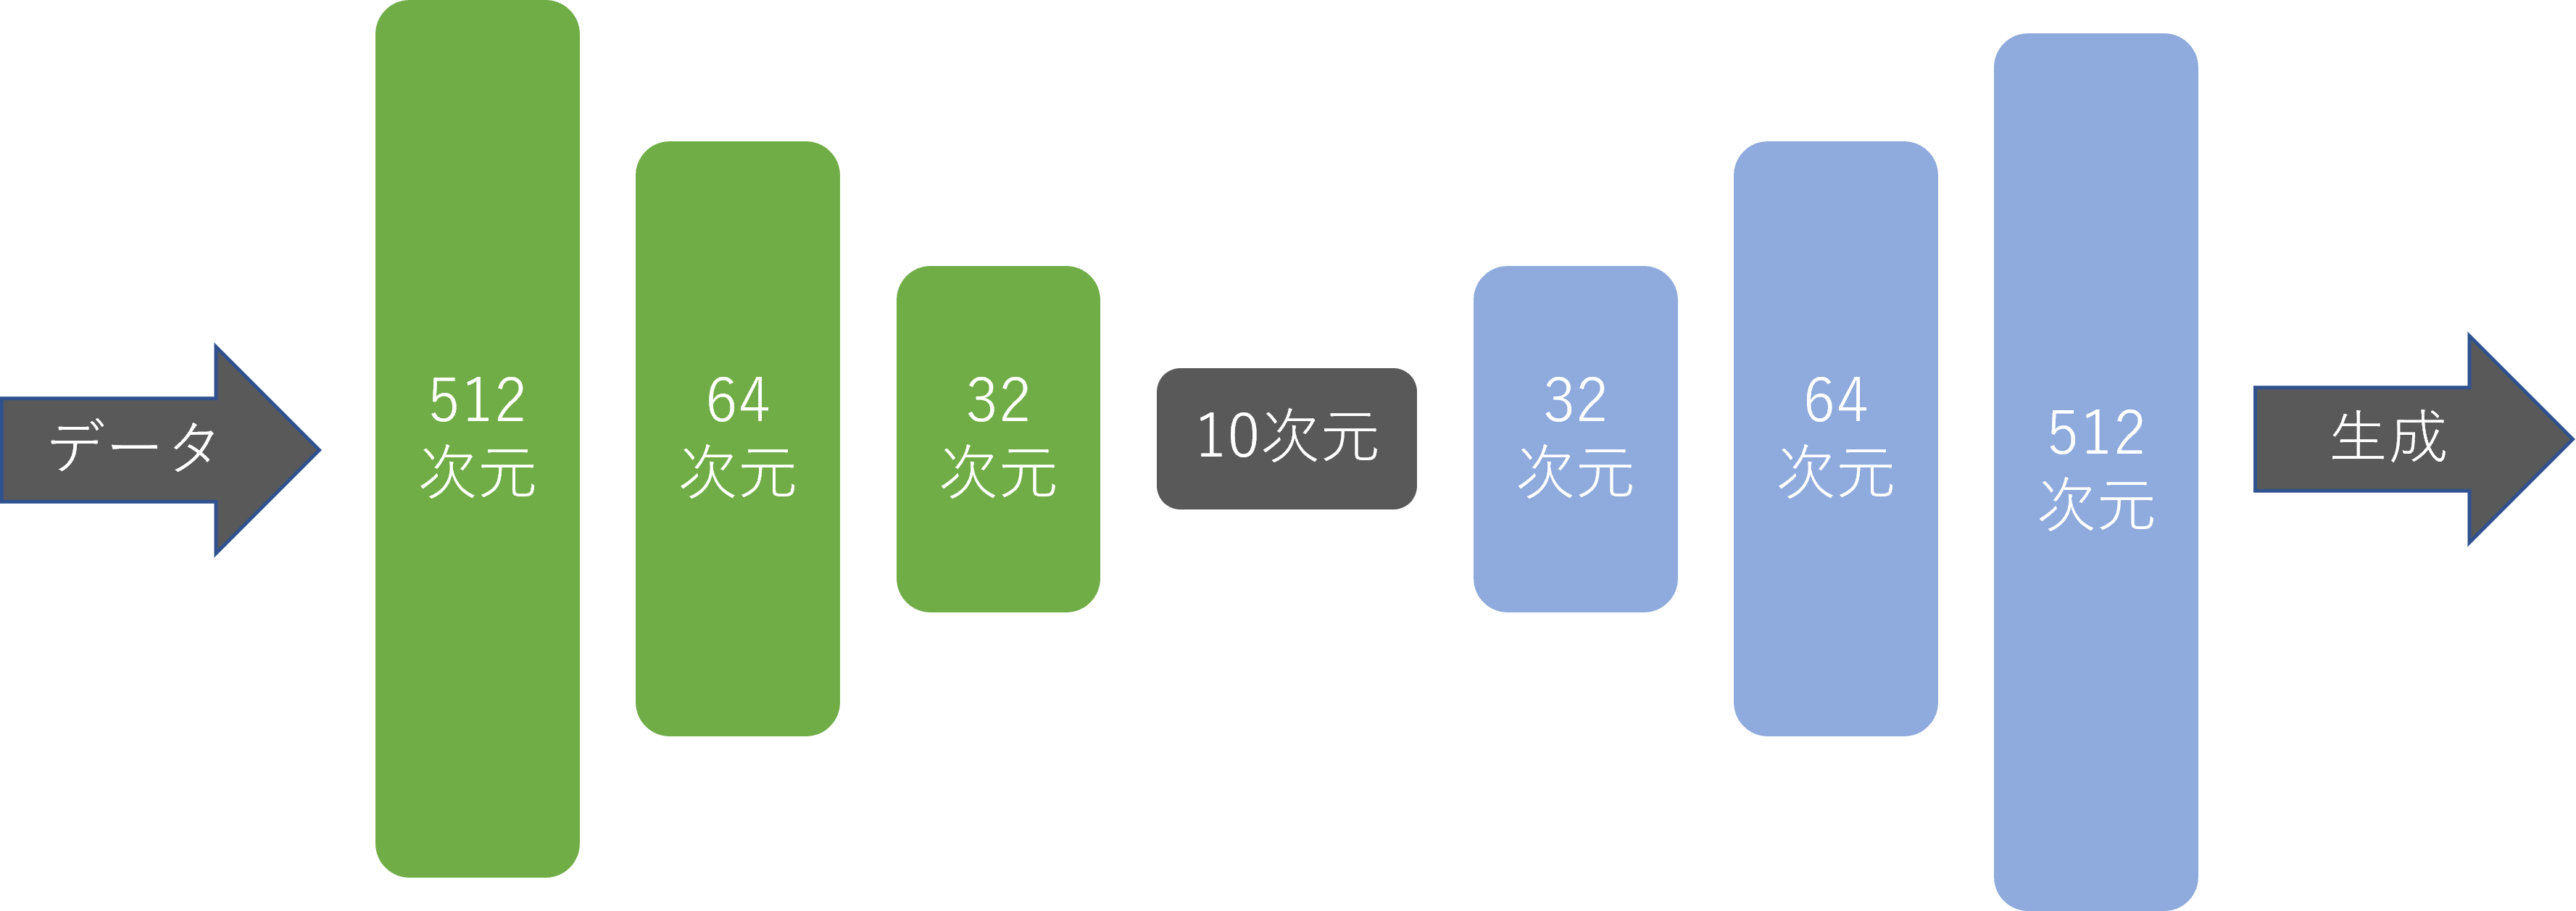

* <font color="Red">問1-1. 【イニシャライザ】第1層ではデータを512次元に圧縮します。データセットの次元を求めて、nn.Linearの引数に入力しましょう。</font><br>
* <font color="Red">問1-2. 【イニシャライザ】最終層では512次元のデータを元の次元に復元します。データセットの次元を求めて、nn.Linearの引数に入力しましょう。</font><br>
* <font color="Red">問1-3. 【encoder関数】エンコーダーでは活性化関数ReLUを介してデータxを各層に読み込ませていきます。**self.dense_enc〇**(〇は1～4の数字)を引数として、encoderの層別構造を記述しよう。なお、encoderの4層目は出力になるため活性化関数は不要です。</font><br>        
* <font color="Red">問1-4. 【decoder関数】問1-2と同様の手順で、decoderの層別構造を記述しましょう。</font><br>

#### AEの損失関数

`reconstruction loss`は入力画像をどれだけ正確に復元できたかを表す損失値です。

交差エントロピー誤差を適応します。

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$

```
【関数の説明】
  nn.Linear(input_dim, output_dim): 全結合層を実装できる関数です。入力データの次元と出力データの次元をそれぞれ`input_dim`, `output_dim`で指定します。
  F.relu(input): テンソルinputに対するReLU関数の出力を返します。
  torch.sigmoid(input): テンソルinputに対するシグモイド関数の出力を返します。
  torch.mean(input, dim): テンソルinputの次元dimに対して平均値を返します。
  torch.sum(input, dim): テンソルinputの次元dimに対して合計値を返します。
```

* <font color="Red">問1-5. 【loss関数】入力 x と出力 y から、損失関数reconstraction lossの値を算出しましょう。

In [ ]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 512) ### 問1-1 ###
        self.dense_enc2 = nn.Linear(512, 64)
        self.dense_enc3 = nn.Linear(64, 32)
        self.dense_enc4 = nn.Linear(32, 10)
        self.dense_dec1 = nn.Linear(10, 32)
        self.dense_dec2 = nn.Linear(32, 64)
        self.dense_dec3 = nn.Linear(64, 512)
        self.dense_dec4 = nn.Linear(512, 28*28) ### 問1-2 ###

    def _encoder(self, x): ### 問1-3 ###
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        x = F.relu(self.dense_enc3(x))
        x = self.dense_enc4(x)
        return x

    def _decoder(self, x): ### 問1-4 ###
        x = F.relu(self.dense_dec1(x))
        x = F.relu(self.dense_dec2(x))
        x = F.relu(self.dense_dec3(x))
        x = torch.sigmoid(self.dense_dec4(x))
        return x

    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x

    def loss(self, x):
        y = self._encoder(x)
        y = self._decoder(y)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1)) ### 問1-5 ###

        return reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

#### <font color="Red">問1 解説</font>

事前知識
```
【関数の説明】
  nn.Linear(input_dim, output_dim): 全結合層を実装できる関数です。入力データの次元と出力データの次元をそれぞれ`input_dim`, `output_dim`で指定します。
  F.relu(input): テンソルinputに対するReLU関数の出力を返します。
  torch.sigmoid(input): テンソルinputに対するシグモイド関数の出力を返します。
  torch.mean(input, dim): テンソルinputの次元dimに対して平均値を返します。
  torch.sum(input, dim): テンソルinputの次元dimに対して合計値を返します。
```

問1-1について、第1層では与えられたデータを`512`次元に圧縮する必要があります。今回与えられたデータはMnistのデータであるため、`28 * 28`次元のデータです。今回はこの`28 * 28`次元のデータを`512`次元にAffine変換を用いて圧縮します。\
`nn.Linear`は第1引数に入力データの次元を入れ、第2引数には出力データの次元を入れる事によって、Affine変換を行うことができます。\
したがって、回答は以下のようになります。

```
self.dense_enc1 = nn.Linear(28*28, 512)
```





問1-2については、問1-1の逆の操作を行う必要があります。AEでは、最終層において、圧縮した`512`次元のデータを元の次元に復元する必要がある。今回与えられたデータはMnistのデータであり、`28 * 28`次元のデータであるため、この次元になるように`512`次元のデータからAffine変換を用いて復元します。\
問1-1同様、`nn.Linear`は第1引数に入力データの次元を入れ第2引数には出力データの次元を入れる事によって、Affine変換を行うことができるため、回答は以下のようになります。

```
self.dense_dec4 = nn.Linear(512, 28*28)
```


問1-3については、encoderでは活性化関数ReLUを介してデータ`x`を各層に読み込ませると書かれてあります。ここではまず、`self.dense_enc1`というencoderの最初の層に関してそのような変換を試みます。

```
x = F.relu(self.dense_enc1(x))
```

`F.relu`はrelu活性化関数を計算するPytorchの関数です。
このように、`self.dense_enc1`にデータ`x`が入力され、そのデータに対して`F.relu`を通す事によってencoderの層を記述することができます。これを複数の層に対して行うことでencoderの層別構造を記述することができます。\
なお、本問題ではencoderの4層目は出力になるため活性化関数は不要であるため、本問題の答えは以下のようになります。

```
def _encoder(self, x):　
    x = F.relu(self.dense_enc1(x))
    x = F.relu(self.dense_enc2(x))
    x = F.relu(self.dense_enc3(x))
    x = self.dense_enc4(x)
    return x
```



問1-4については、問1-3と同様であるため、decoderでは活性化関数ReLUを介してデータ`x`を各層に読み込ませる必要があります。ここではまず、`self.dense_dec1`というdecoderの最初の層に関してそのような変換を試みます。

```
x = F.relu(self.dense_dec1(x))
```

このように、`self.dense_dec1`にデータ`x`が入力され、そのデータに対して`F.relu`を通す事によってdecoderの層を記述することができます。これを複数の層に対して行うことでdecoderの層別構造を記述することができます。\
なお、本問題ではdecoderの4層目の出力として活性化関数であるsigmoid関数を使用する必要があるため、本問題の答えは以下のようになります。
また、活性化関数を通す必要がある理由は、問1-5において、交差エントロピー誤差を用いて、出力値を0〜1の間に収める必要があるからです。

```
def _decoder(self, x):
    x = F.relu(self.dense_dec1(x))
    x = F.relu(self.dense_dec2(x))
    x = F.relu(self.dense_dec3(x))
    x = torch.sigmoid(self.dense_dec4(x))
    return x
```



問1-5については、入力 `x` と出力 `y` から、損失関数reconstraction lossの値を算出します。

reconstruction lossは入力画像をどれだけ正確に復元できたかを表す損失関数です。

reconstruction lossには交差エントロピー誤差を適応します。

$$
\text{reconstruction loss} = \frac{1}{N}\sum^{N}_{i=1} \sum^{C}_{c=1}\{{-x_{ic}\log{y_{ic}}-(1-x_{ic})\log(1-y_{ic})}\}
$$

上記の損失関数を計算するためには、まず、各データに関する入力xとの損失を計算する必要があり、以下の損失を先に考えます。

$$
\sum^{C}_{c=1}\{{-x_{ic}\log{y_{ic}}-(1-x_{ic})\log(1-y_{ic})}\}
$$

こちらの部分をコードに書き起こすと以下のように記述することができます。

```
torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1)
```

`dim=1`となっている理由は各データに対して合計を取るためです。
また、`torch_log`は`torch.log(0)`による`nan`を防ぐための関数であります。

その後、得られた損失についてデータの数で平均を取る必要があるため、問1-5の答えは以下のように表すことができます。

```
reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1))
```

### 学習と評価

学習を進めていくと、次第にtest用データに対する損失がreconstraction_lossに近づいていく様子が分かります。

In [ ]:
AE_model = AE().to(device)
optimizer = optim.Adam(AE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    reconstruction_losses = []
    AE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        AE_model.zero_grad()
        reconstruction_loss = AE_model.loss(x)
        
        loss = reconstruction_loss
        
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    AE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        reconstruction_loss = AE_model.loss(x)

        loss = reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:179.469238, (179.469238), Test Lower Bound:137.428955
EPOCH:2, Train Lower Bound:123.002861, (123.002861), Test Lower Bound:115.798859
EPOCH:3, Train Lower Bound:109.628464, (109.628464), Test Lower Bound:107.909576
EPOCH:4, Train Lower Bound:103.275185, (103.275185), Test Lower Bound:103.834190
EPOCH:5, Train Lower Bound:99.388252, (99.388252), Test Lower Bound:99.103340
EPOCH:6, Train Lower Bound:96.106873, (96.106873), Test Lower Bound:96.472588
EPOCH:7, Train Lower Bound:93.831863, (93.831863), Test Lower Bound:94.870384
EPOCH:8, Train Lower Bound:92.085678, (92.085678), Test Lower Bound:93.076996
EPOCH:9, Train Lower Bound:90.445526, (90.445526), Test Lower Bound:90.878143
EPOCH:10, Train Lower Bound:88.614700, (88.614700), Test Lower Bound:89.207100
EPOCH:11, Train Lower Bound:87.158020, (87.158020), Test Lower Bound:88.418953
EPOCH:12, Train Lower Bound:86.128448, (86.128448), Test Lower Bound:87.599831
EPOCH:13, Train Lower Bound:85.335922, (85.335922

### 元画像と復元画像の比較

テスト用データの画像を入力として、AEで再構成した画像と比較してみましょう。

まずはオリジナルのテスト用データの画像を表示します。

In [ ]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、AEで再構成した画像を表示します。

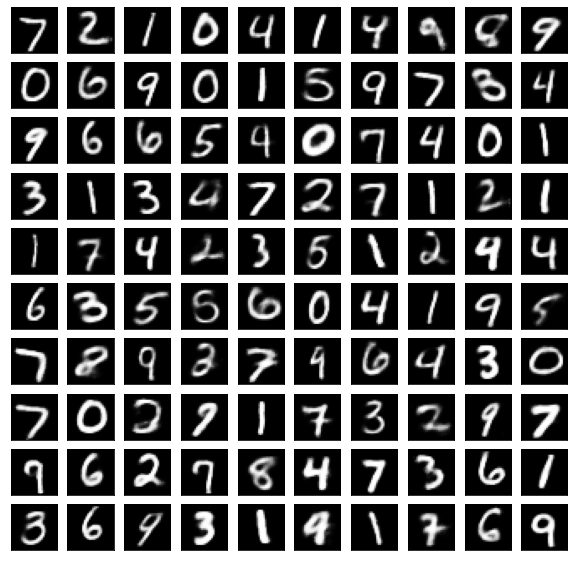

In [ ]:
# AEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
AE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y = AE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## VAEによるMNISTの画像生成（PyTorch） 
#### VAEとは

エンコーダの目的はデータ分布を生成することです。

AEはもともと存在するデータを忠実に再現しようとします。しかし、忠実に再現しようとした結果、「遊び」がなく、連続性の高いデータ分布を生成することが出来ません。

そこでVAE(Variational Autoencoder)では、入力データを圧縮して得られる潜在変数を確率変数として表します。さらに潜在変数をガウス分布からサンプリングする制約を設けることでデータの潜在空間上での分布に連続性を持たせることが出来ます。

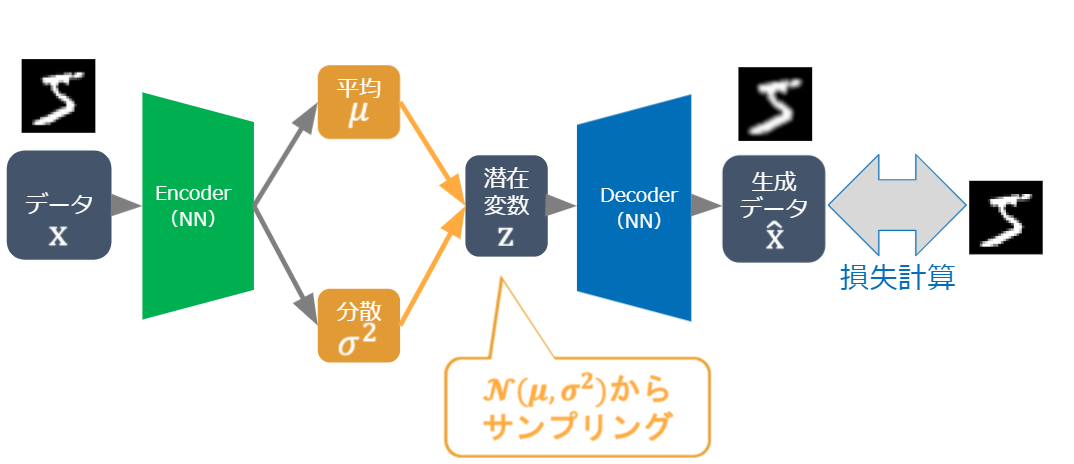

#### VAEのアルゴリズム



1. <font color='Green'>Encoder</font>により、データから$x$から潜在変数$z$の分布の平均$\mu$と分散$\sigma^2$を出力する。<br>
2. 出力された平均$\mu$と分散$\sigma$のガウス分布に従う潜在変数$z$をサンプリングする。<br>
3. <font color='Blue'>Decoder</font>により、潜在変数$z$から新たなデータ$\hat{x}$を生成する。<br>
4. 以下の損失関数により損失計算

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$
$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$
$$
\rm{loss} = \rm{reconstruction~loss} + \rm{KL}
$$

* <font color="Red">問2-1,2-2. 【encoder関数】平均，分散の算出式を記述</font><br>
* <font color="Red">問2-3. 【sampling関数】ガウス分布を算出する関数を完成させるてください。</font><br>
【ヒント】
ガウス分布からランダムに抽出された値を$\epsilon$とすると、ガウス分布に従う潜在変数$z$は以下のように算出されます。
$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


#### VAEの損失関数

KLダイバージェンスを使った損失は以下のように算出されます。

$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$

* <font color="Red">問2-4. 【loss関数】KL_lossの算出を記述してください。</font><br>

In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x) ### 問2-1 ###
        var = F.softplus(self.dense_encvar(x)) ### 問2-2 ###
        return mean, var

    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape) 
        return mean + torch.sqrt(var) * epsilon ### 問2-3 ###

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, var = self._encoder(x)
        # KL lossの計算
        KL = -0.5 * torch.mean(torch.sum(1 + self.torch_log(var) - mean**2 - var, dim=1)) ### 問2-4 ###

        z = self._sample_z(mean, var)
        y = self._decoder(z)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1))

        return KL, reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

#### <font color="Red">問2 解説</font>

問2-1,2-2について、encoderによって、平均，分散の算出式を記述するという問題であり、`mean`、`var`については各々以下のように記述することができます。

```
mean = self.dense_encmean(x)
```

```
var = F.softplus(self.dense_encvar(x))
```

encoder自体は以下のように記述することができ、
`F.relu(self.dense_enc1(x))`と`F.relu(self.dense_enc2(x))`という層を通った後に、これらの層によって得られたデータから`mean`、`var`をAffine変換を施すことによって算出することができるモデルがVAEです。
```
def _encoder(self, x):
    x = F.relu(self.dense_enc1(x))
    x = F.relu(self.dense_enc2(x))
    mean = self.dense_encmean(x)
    var = F.softplus(self.dense_encvar(x))
    return mean, var
```


encodeにより、データから$x$から潜在変数$z$の分布の平均$\mu$と分散$\sigma^2$を出力します。


問2-3について、ガウス分布を算出する関数を作成するため、pytorchのガウス分布からサンプリングする関数である`torch.randn`を利用します。


```
epsilon = torch.randn(mean.shape) 
```

ガウス分布からランダムに抽出された値を$\epsilon$とすると、平均$\mu$と分散$\sigma$のガウス分布に従う潜在変数$z$は以下のガウス分布に従います。

$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$

上記のReparametrization Trickを利用して、$\mathcal{N}(\boldsymbol\mu,\Sigma)$からサンプリングするコードを記述します。

```
def _sample_z(self, mean, var):
    epsilon = torch.randn(mean.shape) 
    return mean + torch.sqrt(var) * epsilon
```

これによって、得られる潜在変数ベクトルは$\mathcal{N}(\boldsymbol\mu,\Sigma)$に従います。


問2-4について、KL_lossの算出を算出する必要があるため、まず、以下の損失関数を確認します。

$$
\text{KL} =  - \frac{1}{N}\sum^{N}_{i=1} \sum^{D}_{d=1}{(1+\log\sigma^2_{id}-\mu^2_{id}-\sigma^2_{id})}
$$


上記の関数を計算するために、`self._encoder(x)`によって得られ平均値(ベクトル)`mean`と分散`var`を利用する。これらを利用して記述すると以下のようになります。

```
KL = -0.5 * torch.mean(torch.sum(1 + self.torch_log(var) - mean**2 - var, dim=1))
```


### 学習と評価

In [ ]:
z_dim = 2#10
VAE_model = VAE(z_dim).to(device)
optimizer = optim.Adam(VAE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    VAE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        VAE_model.zero_grad()
        KL_loss, reconstruction_loss = VAE_model.loss(x)  # lossの各項の計算

        loss = KL_loss + reconstruction_loss  # 和を取ってlossとする

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    VAE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        KL_loss, reconstruction_loss = VAE_model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:190.702255, (3.650046, 187.052200), Test Lower Bound:172.145645
EPOCH:2, Train Lower Bound:164.472107, (4.962545, 159.509552), Test Lower Bound:163.112198
EPOCH:3, Train Lower Bound:158.757767, (5.325654, 153.432098), Test Lower Bound:158.273743
EPOCH:4, Train Lower Bound:155.384247, (5.556186, 149.828079), Test Lower Bound:154.558334
EPOCH:5, Train Lower Bound:152.882385, (5.720274, 147.162125), Test Lower Bound:153.287460
EPOCH:6, Train Lower Bound:150.701660, (5.866714, 144.834946), Test Lower Bound:151.063690
EPOCH:7, Train Lower Bound:149.188980, (5.955876, 143.233109), Test Lower Bound:149.808716
EPOCH:8, Train Lower Bound:148.065033, (6.030299, 142.034729), Test Lower Bound:149.103058
EPOCH:9, Train Lower Bound:146.845779, (6.111445, 140.734329), Test Lower Bound:147.430588
EPOCH:10, Train Lower Bound:146.335358, (6.141803, 140.193573), Test Lower Bound:147.358383
EPOCH:11, Train Lower Bound:145.631256, (6.200351, 139.430893), Test Lower Bound:146.5082

### 元画像と復元画像の比較

テスト用データの画像を入力として、VAEで再構成した画像と比較してみましょう。

まずはオリジナルのテスト用データの画像を表示します。

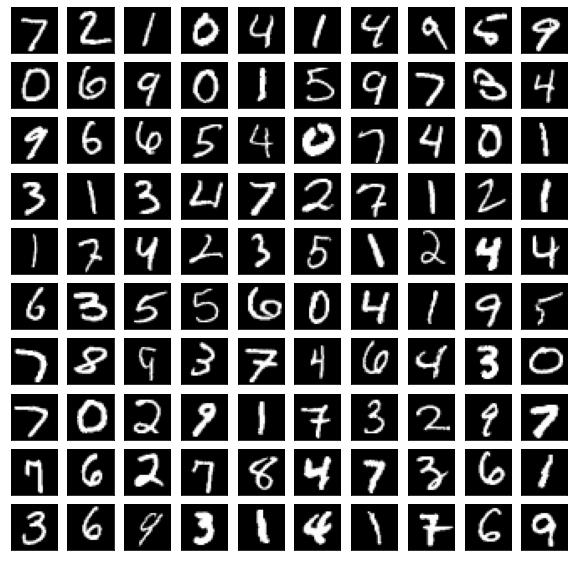

In [ ]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、VAEで再構成した画像を表示します。

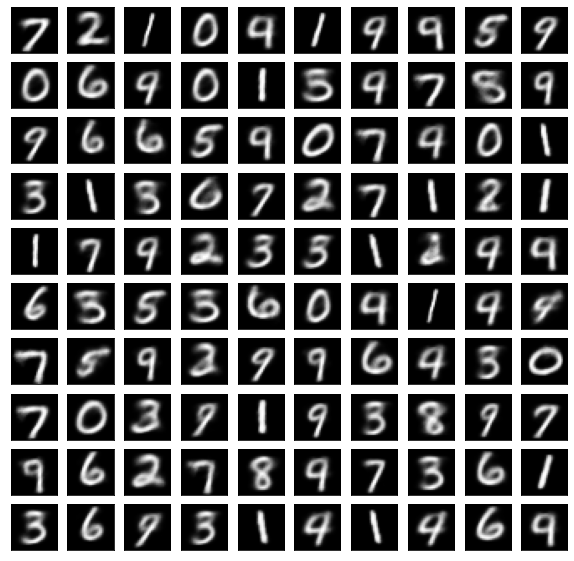

In [ ]:
# VAEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = VAE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

潜在変数からランダムサンプリングしてイメージを生成すると、以下のようになります。

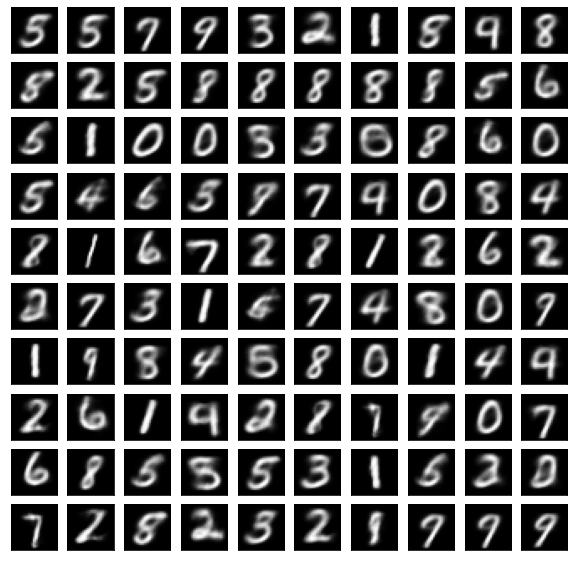

In [ ]:
# 潜在変数からランダムサンプリング(潜在変数をランダムに決め, その潜在変数から生成されるMNISTイメージ)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    z = torch.randn([1, z_dim]).to(device)
    y = VAE_model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

最後に、潜在変数による連続的な変化を可視化してみましょう。

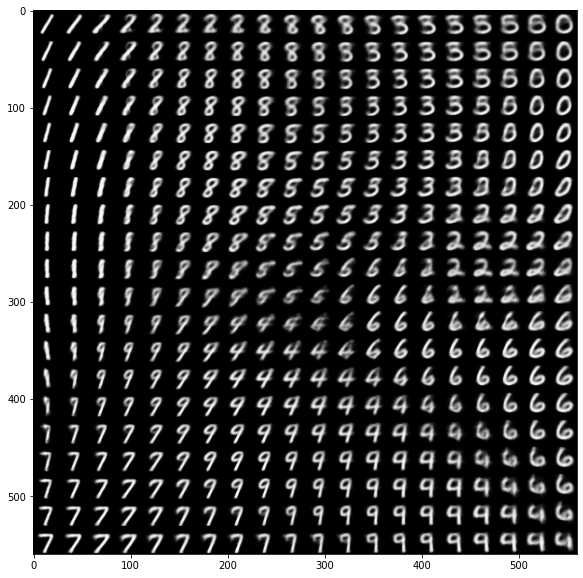

In [ ]:
# 多様体の可視化
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.from_numpy(z_sample.astype(np.float32)).clone()
        x_decoded = VAE_model._decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.to('cpu').detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()